In [2]:
import numpy as np
import pandas as pd
import os
import sys
import cv2

import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS'] 

from stack_image_new import stack_images
from dataloader import split_dual_xray_image, get_contours, path2pixel
from preprocessing import get_contour_pixels, get_contour_box_image

In [109]:
from importlib import reload
import stack_image_new
reload(stack_image_new)
from stack_image_new import stack_images, stack_tif

In [4]:
current_dir = os.getcwd()
code_path = os.path.abspath(os.path.join(current_dir, '..', '..', 'codes'))
data_path = os.path.abspath(os.path.join(current_dir, '..', '..', 'data'))

In [5]:
from classifiers.r_method import RMethodClassifier

In [364]:
test_image = cv2.imread('/Users/zhengyun/Desktop/yaojian/codes/ore_sort_cpp-master/img/160kV_4mA_pressure_test3_forward.png', cv2.IMREAD_GRAYSCALE)
low_test, high_test = split_dual_xray_image(test_image[: :].T)
low_test, high_test = low_test.T, high_test.T

# test_image = cv2.imread('/Users/zhengyun/Desktop/yaojian/codes/ore_sort_cpp-master/img/160kV_4mA_forward.png', cv2.IMREAD_GRAYSCALE)
# low_test, high_test = split_dual_xray_image(test_image.T)
# low_test, high_test = low_test.T, high_test.T

In [365]:
R_0219 = RMethodClassifier(pixels=[low_test, high_test], truth=None, I0_low=195, I0_high=196, input= 'images', method= 'a', const= [5, 20], include_Fe = False)


In [7]:
# plt.imshow(R_0219.R_pixels[:, 250:1250], vmin=0, vmax=0.78)
# plt.colorbar()

In [8]:
# plt.imshow(R_0219.R_pixels[:, 250:1250] > 0.78)
# # plt.colorbar()

In [ ]:

def get_bricks(path = 'all_unnorm.png', roi = [200, -1, 600, 800], th_val = 175):
    data_int8 = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    print(data_int8[0:300, 200:1000].mean(), data_int8[0:300, 2000:2500].mean())
    # all_unnorm = all_unnorm.astype(np.int8)
    low_ori, high_ori = split_dual_xray_image(data_int8.T)
    low, high = low_ori.T[roi[0]:roi[1], roi[2]:roi[3]], high_ori.T[roi[0]:roi[1], roi[2]:roi[3]]
    extra_bottom = low[0:10, :]
    low, high = np.vstack((low, extra_bottom)), np.vstack((high, extra_bottom))

    r_image = compute_R(low, high, I0_low = 195, I0_high = 196, 
                     input = 'images', method = 'a', const = [5, 20])
    print(low.shape, r_image.shape)
    _, thresholded = cv2.threshold(low.copy(), th_val, 255, cv2.THRESH_BINARY)

    # Find contours using cv2.RETR_TREE and cv2.CHAIN_APPROX_SIMPLE
    contours, hierarchy = cv2.findContours(thresholded, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    print(len(contours))
    contoured = cv2.cvtColor(low, cv2.COLOR_GRAY2BGR).copy()
    contoured_r = r_image.copy() #cv2.cvtColor(r_image, cv2.COLOR_GRAY2BGR).copy()

    cnt_filtered = []
    pixels = []; r_pixels = []
    for cnt in contours:
        if cv2.contourArea(cnt) > 100 and cv2.contourArea(cnt) < 50000:
            cnt_filtered.append(cnt)
    cnt_filtered = sorted(cnt_filtered, key=lambda c: ((cv2.boundingRect(c)[1])))

    box_images = []

    for cnt in cnt_filtered:
        pixels_i_low, pixels_i_high, r_values_i = get_contour_pixels(low, cnt), get_contour_pixels(high, cnt), get_contour_pixels(r_image, cnt)
        pixels.append([pixels_i_low, pixels_i_high]); r_pixels.append(r_values_i)
        # print(len(pixels_i_low), len(pixels_i_high), len(r_values_i))

        box_low, box_high, box_r= get_contour_box_image(low, cnt, margin = 0), get_contour_box_image(high, cnt, margin = 0), get_contour_box_image(r_image, cnt, margin = 0)
        box_images.append([box_low, box_high, box_r])

    _ = cv2.drawContours(contoured, cnt_filtered, -1, (0, 0, 255), 2)
    _ = cv2.drawContours(contoured_r, cnt_filtered, -1, (0, 0, 255), 2)
    for contour, text_i in zip(cnt_filtered, np.arange(6)):
        # Calculate the centroid of the contour
        M = cv2.moments(contour)
        if M["m00"] != 0:
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
        else:
            cX, cY = 0, 0

        # Put the index number near the contour
        cv2.putText(contoured, str(text_i), (cX, cY), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 0), 2)

    # plt.imshow(thresholded, cmap='gray')
    # plt.colorbar()

    return pixels, contoured, [low_ori.T, high_ori.T], r_pixels, contoured_r, box_images


In [ ]:
def compute_R(low, high, I0_low = 195, I0_high = 196, input = 'images', method = 'a', const = [5, 20]):

    '''
    input: 'images' or 'pixels', whole images of low and high energy or pixels of rocks
    
    '''

    if input == 'images':
        if method == 'a':
            return np.log(I0_low/(low+1e-6) + const[0] )/np.log(I0_high/(high+1e-6) + const[1])

        elif method == 'b':
            return np.log((low + 1e-6))/(np.log(high+1e-6 + 200.0))
        
    elif input == 'pixels':
        R_values = []
        for i in range(len(low)):

            if method == 'a':
                R_i =np.log(I0_low/(low[i]+1e-6) + const[0] )/np.log(I0_high/(high[i]+1e-6) + const[1])

            elif method == 'b':
                R_i = np.log((low[i] + 1e-6))/(np.log(high[i]+1e-6 + 200.0))   
            R_values.append(R_i)

        return R_values

# contour test

In [226]:
low_roi.shape

(880, 800)

In [230]:
low_roi.resize

<function ndarray.resize>

In [239]:
path_0227 = os.path.join(data_path, '20250227/160kV_4mA_forward.png')

image = cv2.imread(path_0227, cv2.IMREAD_GRAYSCALE)
low, high = split_dual_xray_image(image.T) #为了与函数输入一致，先将图像transpose
low, high = low.T, high.T # 先转置回来
roi = [20, 900, 320, 1120]
y1, y2, x1, x2 = roi
low_roi, high_roi = cv2.flip(low[y1:y2, x1:x2], 0), cv2.flip(high[y1:y2, x1:x2], 0) 

low_re, high_re = cv2.resize(low_roi, (low_roi.shape[0]//4, low_roi.shape[1]//4)), cv2.resize(high_roi, (high_roi.shape[0]//4, high_roi.shape[1]//4))
low_contoured, rock_pixels, contours = get_contours(low_re, high_re, th_val = 128, max_len = 6, length=102, 
                                              direction = 'ublr', path = path_0227, s_i = 0, save_rock_image=False)


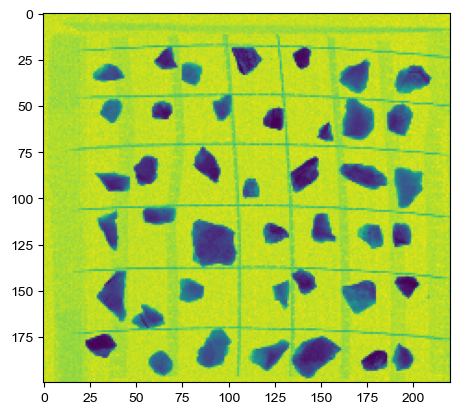

In [238]:
plt.imshow(low_re)

# Standard Sample

In [39]:
import pickle

with open('input_0219_0224_0225_0226_0227_contour_th_128.pkl', 'rb') as f:
    input_all = pickle.load(f)
pixels = input_all[0]
data = input_all[1]

input_all = []
for t in range(5):
    index_d = data.loc[data['source'] == 'source_%s'%t].index.values
    input_d = [[pixels[0][index_d], pixels[1][index_d]], data.loc[index_d]]
    input_all.append(input_d)
input_names = ['0219', '0224', '0225', '0226', '0227', 'all']

In [ ]:
# data_new = os.path.abspath(os.path.join(current_dir, '..', '..', 'data', '20250515'))


In [110]:
data_new = os.path.abspath(os.path.join(current_dir, '..', '..', 'data', '20250604'))
stack_tif(data_new, height_factor = 6) 
sample_path = '/Users/zhengyun/Desktop/yaojian/data/20250604/sample_normalized/sample_normalized.png'
sample_norm, contoured_norm, image_norm, r_pixels_norm, contoured_r_norm, box_norm = get_bricks(sample_path, roi = [0, -1, 700, 900], th_val = 175)


['.DS_Store', 'normalized_1_50.png', 'normalized_50_100.png']
['.DS_Store', 'foo130.tif', 'foo131.tif', 'foo132.tif', 'foo133.tif', 'foo134.tif', 'foo135.tif', 'foo136.tif', 'foo137.tif', 'foo138.tif', 'foo139.tif', 'foo140.tif', 'foo141.tif', 'foo142.tif', 'normalized_50_100.png']
['.DS_Store', 'foo171.tif', 'foo172.tif', 'foo173.tif', 'foo174.tif', 'foo175.tif', 'foo176.tif', 'foo177.tif', 'foo178.tif', 'foo179.tif', 'foo180.tif', 'foo181.tif', 'foo182.tif', 'unnormalized_1_50.png']
['.DS_Store', 'foo186.tif', 'foo187.tif', 'foo188.tif', 'foo189.tif', 'foo190.tif', 'foo191.tif', 'foo192.tif', 'foo193.tif', 'foo194.tif', 'foo195.tif', 'foo196.tif', 'foo197.tif', 'normalized_1_50.png']
['.DS_Store', 'foo103.tif', 'foo104.tif', 'foo105.tif', 'foo106.tif', 'foo107.tif', 'foo108.tif', 'foo109.tif', 'foo110.tif', 'foo111.tif', 'foo112.tif', 'sample_unnormalized.png']
['.DS_Store', 'foo108.tif', 'foo109.tif', 'foo110.tif', 'foo111.tif', 'foo112.tif', 'foo113.tif', 'foo114.tif', 'foo115.tif'

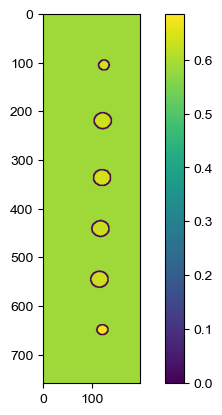

In [115]:
# plt.imshow(contoured_norm)
plt.imshow(contoured_r_norm)
plt.colorbar()

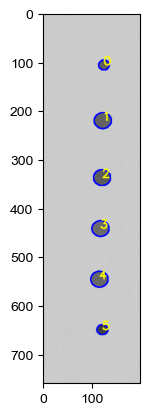

In [114]:
plt.imshow(contoured_norm)
# 

In [27]:
sample_norm[1][0].mean()

113.19251336898395

In [31]:
len(sample_norm[0][0])

369

In [57]:
for i in range(len(r_pixels_norm)):
    print(sample_norm[i][0].mean(), sample_norm[i][0].std(), sample_norm[i][1].mean(), sample_norm[i][1].std(),r_pixels_norm[i].mean(), r_pixels_norm[i].std())

117.07046070460704 37.553797653711875 149.97018970189703 21.164645066171587 0.6255173303251818 0.018935918698259387
113.19251336898395 30.424612672141304 147.18716577540107 17.81089752305584 0.6262344541488617 0.01498644770135495
108.02467811158799 32.690649665312016 143.37124463519314 19.54425893323066 0.630870151362421 0.01714899433792823
120.87947882736157 27.77401479980369 153.06623235613463 15.947830250966884 0.6204316678698715 0.012919382902903538
115.94809322033899 29.566150634016324 148.77330508474577 17.519344250705274 0.6239854781294206 0.014019582062489912
93.66753246753247 48.924204408739925 122.41818181818182 34.92491659677397 0.6521658360398949 0.03388040376743731


In [61]:
filtered_data = data[(data['Zn_Pb_grade'] > 2.9) & (data['Zn_Pb_grade'] < 3.01)]
indices = filtered_data.index.values

In [62]:
for i in indices:
    print(pixels[0].iloc[i].mean(), pixels[0].iloc[i].std(), pixels[1].iloc[i].mean(), pixels[1].iloc[i].std())

56.92418772563177 35.656592206516976 80.6549338146811 39.933734254309535
50.048632218844986 40.05113666863916 71.87369132049983 43.302969490380896
55.89712800198069 29.287494010979074 80.36011388957662 29.6829233430529


In [19]:
pt_path = os.path.join(data_path, '160kV_4mA_pressure_test3_forward.png')
pre_test = cv2.imread(pt_path, cv2.IMREAD_GRAYSCALE) #cv2.IMREAD_UNCHANGED

In [20]:
pre_test.max()

255

In [131]:
all_unnorm = stack_images(data_path, 1, 3)
# cv2.imwrite('all_unnorm.png', all_unnorm)
all_norm = stack_images(data_path, 4, 7) 
# cv2.imwrite('all_norm.png', all_norm)
stack_norm = stack_images(data_path, 8, 10) 
# cv2.imwrite('stack_norm.png', stack_norm)

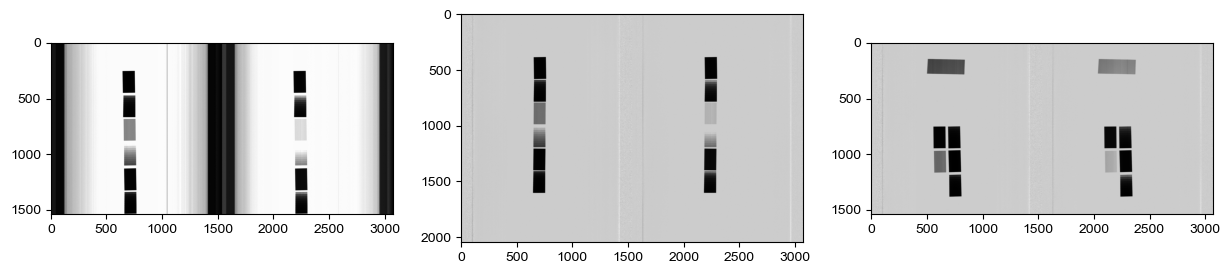

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(all_unnorm, cmap='gray')
axes[1].imshow(all_norm, cmap='gray')
axes[2].imshow(stack_norm, cmap='gray')

In [143]:
data_int16 = cv2.imread('all_unnorm.png', cv2.IMREAD_UNCHANGED)
low_ori_16, high_ori_16 = split_dual_xray_image(data_int16.T)


In [116]:
data_int8.dtype

dtype('uint8')

In [138]:
data_int8 = cv2.imread('all_unnorm.png', cv2.IMREAD_GRAYSCALE)
roi = [200, -1, 600, 800]; th_val = 175
# all_unnorm = all_unnorm.astype(np.int8)
low_ori, high_ori = split_dual_xray_image(data_int8.T)
low, high = low_ori.T[roi[0]:roi[1], roi[2]:roi[3]], high_ori.T[roi[0]:roi[1], roi[2]:roi[3]]
extra_bottom = low[0:10, :]
low, high = np.vstack((low, extra_bottom)), np.vstack((high, extra_bottom))
_, thresholded = cv2.threshold(low.copy(), th_val, 255, cv2.THRESH_BINARY)

# Find contours using cv2.RETR_TREE and cv2.CHAIN_APPROX_SIMPLE
contours, hierarchy = cv2.findContours(thresholded, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
print(len(contours))


cnt_filtered = []
pixels = []; r_pixels = []
for cnt in contours:
    if cv2.contourArea(cnt) > 500 and cv2.contourArea(cnt) < 50000:
        cnt_filtered.append(cnt)
cnt_filtered = sorted(cnt_filtered, key=lambda c: ((cv2.boundingRect(c)[1])))

for cnt in cnt_filtered:
    pixels_i_low = get_contour_pixels(low, cnt)
    pixels.append([pixels_i_low])

9


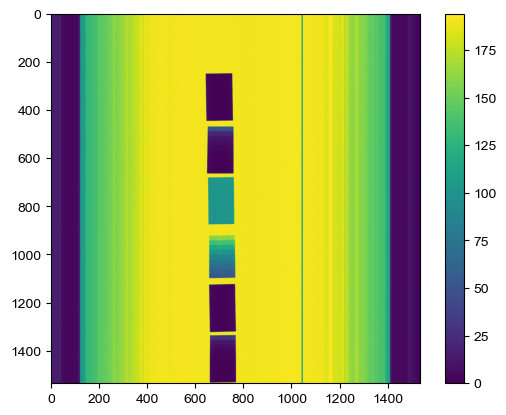

In [107]:
plt.imshow(low_ori.T)
plt.colorbar()

Text(0.5, 1.0, 'Empty image 0-220 rows')

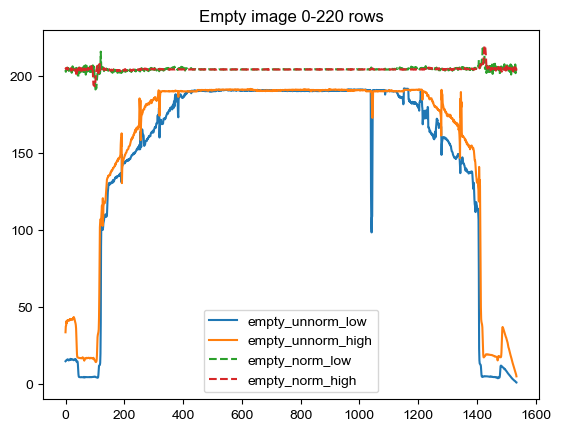

In [167]:
plt.plot(image_unnorm[0][0:200, :].mean(axis = 0), label = 'empty_unnorm_low')
# plt.plot(low_ori_16.T[0:220, :].mean(axis = 0))
plt.plot(image_unnorm[1][0:200, :].mean(axis = 0), label = 'empty_unnorm_high')

plt.plot(image_norm[0][0:200, :].mean(axis = 0), '--', label = 'empty_norm_low')
plt.plot(image_norm[1][0:200, :].mean(axis = 0), '--', label = 'empty_norm_high')
plt.legend()
plt.title('Empty image 0-220 rows')

Text(0.5, 1.0, 'Empty image 0-220 rows')

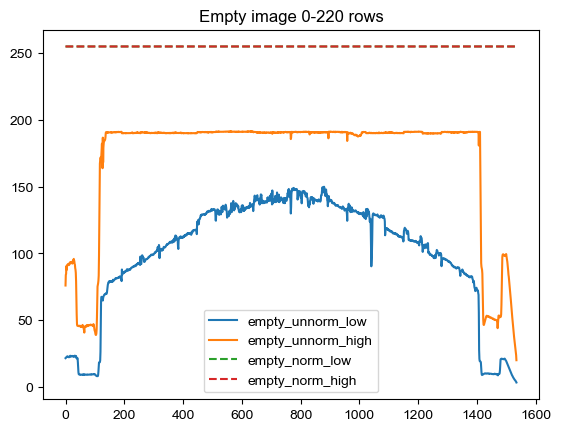

In [317]:
plt.plot(small_focal_unnorm[2][0][-200:-1, :].mean(axis = 0), label = 'empty_unnorm_low')
# plt.plot(low_ori_16.T[0:220, :].mean(axis = 0))
plt.plot(small_focal_unnorm[2][1][0:200, :].mean(axis = 0), label = 'empty_unnorm_high')

plt.plot(small_focal[2][0][-200:-1, :].mean(axis = 0), '--', label = 'empty_norm_low')
plt.plot(small_focal[2][1][-200:-1, :].mean(axis = 0), '--', label = 'empty_norm_high')
plt.legend()
plt.title('Empty image 0-220 rows')

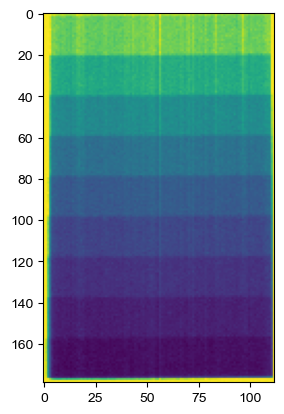

In [213]:
plt.imshow(box_norm[3][0])

Text(0.5, 1.0, 'High')

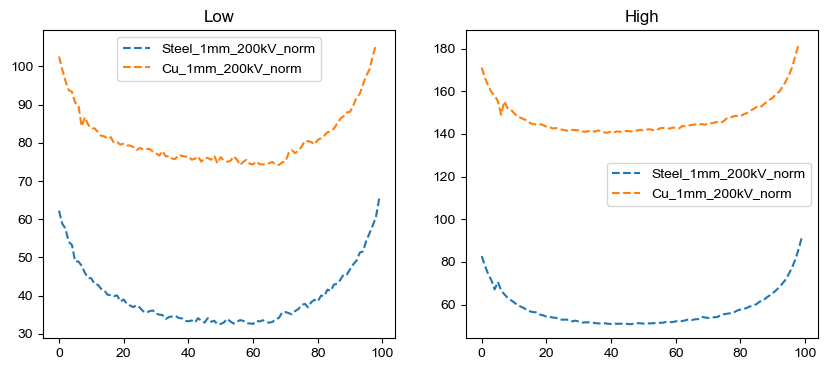

In [311]:
fig, axes = plt.subplots(1, 2, figsize = (10, 4))
for k in range(2):
    for i in [0, 2]:
        # 0,4 for old images; 0, 2 for small focal images
        if i == 0:
            material = 'Steel'
        elif i == 2:
            material = 'Cu'
        # axes[k].plot(box_unnorm[i][k][10:-10, 5:-5].mean(axis = 0), label = material + '_unnorm')
        # axes[k].plot(box_norm[i][k][10:-10, 5:-5].mean(axis = 0), '--', label = material + '_norm')
        axes[k].plot(small_focal[-1][i][k][10:-10, 5:-5].mean(axis = 0), '--', label = material + '_1mm_200kV_norm')
        # axes[k].plot(small_focal_unnorm[-1][int(i*2)][k][10:-10, 5:-5].mean(axis = 0), label = material + '_1mm_200kV_unnorm')
        axes[k].legend()
axes[0].set_title('Low')
axes[1].set_title('High')

In [314]:
small_focal = get_bricks(path = '200kV_4mA_1mm_norm.png', roi = [200, -1, 600, 900], th_val = 210)
small_focal_unnorm = get_bricks(path = '200kV_4mA_1mm_unnorm.png', roi = [200, -1, 700, 900], th_val = 100)

249.83269583333333 247.48891333333333
(1309, 300) (1309, 300)
37
115.96415416666666 190.66257333333334
(1309, 200) (1309, 200)
6


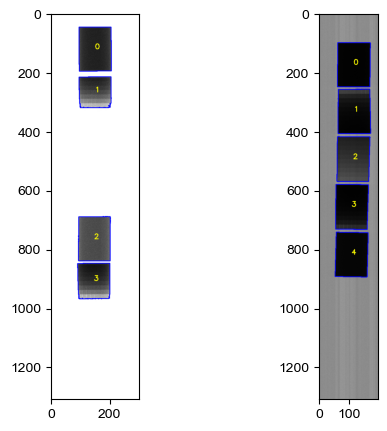

In [315]:
fig, axes = plt.subplots(1, 2, figsize=(6, 5))
axes[0].imshow(small_focal[1])
axes[1].imshow(small_focal_unnorm[1])

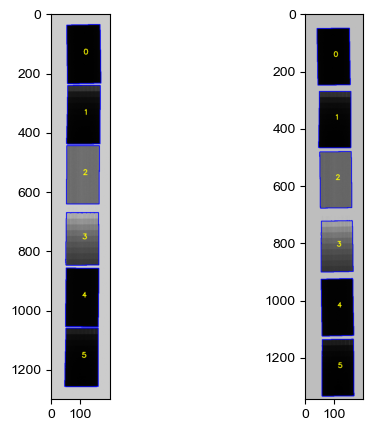

In [326]:
fig, axes = plt.subplots(1, 2, figsize=(6, 5))
axes[0].imshow(contoured_norm[150:1450, :]) 
axes[1].imshow(contoured_unnorm)

In [176]:
all_unnorm, contoured_unnorm, image_unnorm, r_pixels_unnorm, contoured_r_unnorm, box_unnorm = get_bricks('all_unnorm.png', roi = [200, -1, 600, 800], th_val = 175)


179.84055 184.13007333333334
(1345, 200) (1345, 200)
9


204.26615 204.19745333333333
(1857, 200) (1857, 200)
13
180.56735416666666 182.45096666666666
(945, 500) (945, 500)
9


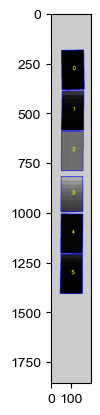

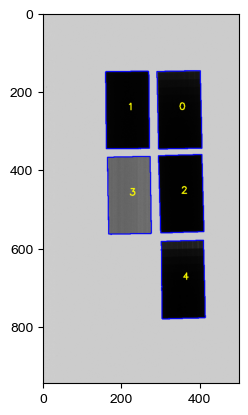

In [118]:
all_norm, contoured_norm, image_norm, r_pixels_norm, contoured_r_norm, box_norm = get_bricks('all_norm.png', roi = [200, -1, 600, 800], th_val = 191)
plt.figure()
plt.imshow(contoured_norm, cmap='gray')

stack_norm, contoured_stack_norm, image_stack_norm, r_pixels_stack_norm, contoured_r_stack_norm, box_stack_norm = get_bricks('stack_norm.png', roi = [600, -1, 400, 900], th_val = 191)
plt.figure()
plt.imshow(contoured_stack_norm, cmap='gray')

In [344]:
for r_pixel in r_pixels_norm:
    print(r_pixel.mean(), r_pixel.std())

1.0714251121734493 0.1440268002124499
1.0005351480940423 0.1764426729070355
0.6258526811099594 0.007836845073817876
0.6384684797235727 0.031194964529118064
1.1097183756955482 0.14147466737546086
1.0217293935526772 0.17783624109503915


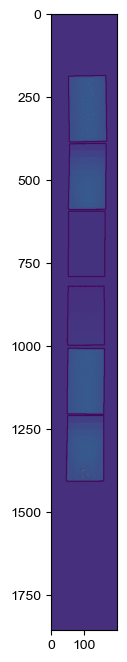

In [123]:
plt.figure(figsize=(10, 8))
plt.imshow(contoured_r_norm)

In [177]:
def draw_multiple_rectangles(image, num_boxes):
    # 复制原图，避免修改原图
    img_with_boxes = image.copy()
    for i in range(num_boxes):
        # 计算左上角和右下角坐标
        y1 = i * 20 + 5
        y2 = i * 20 + 15
        x1 = 10
        x2 = 105
        # 绘制矩形框，颜色为绿色，线宽为 2
        cv2.rectangle(img_with_boxes, (x1, y1), (x2, y2), (0.5, 0.5, 0), 1)
    return img_with_boxes

In [178]:
test = draw_multiple_rectangles(al_R, 9)

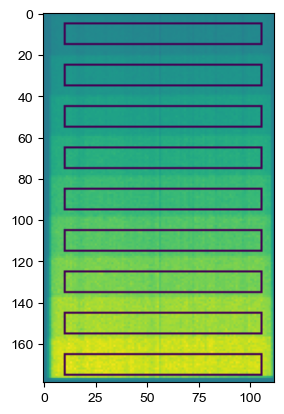

In [179]:
plt.imshow(test)

In [188]:
names = ['Steel', 'Steel_step', 'Al', 'Al_step', 'Cu', 'Cu_step']

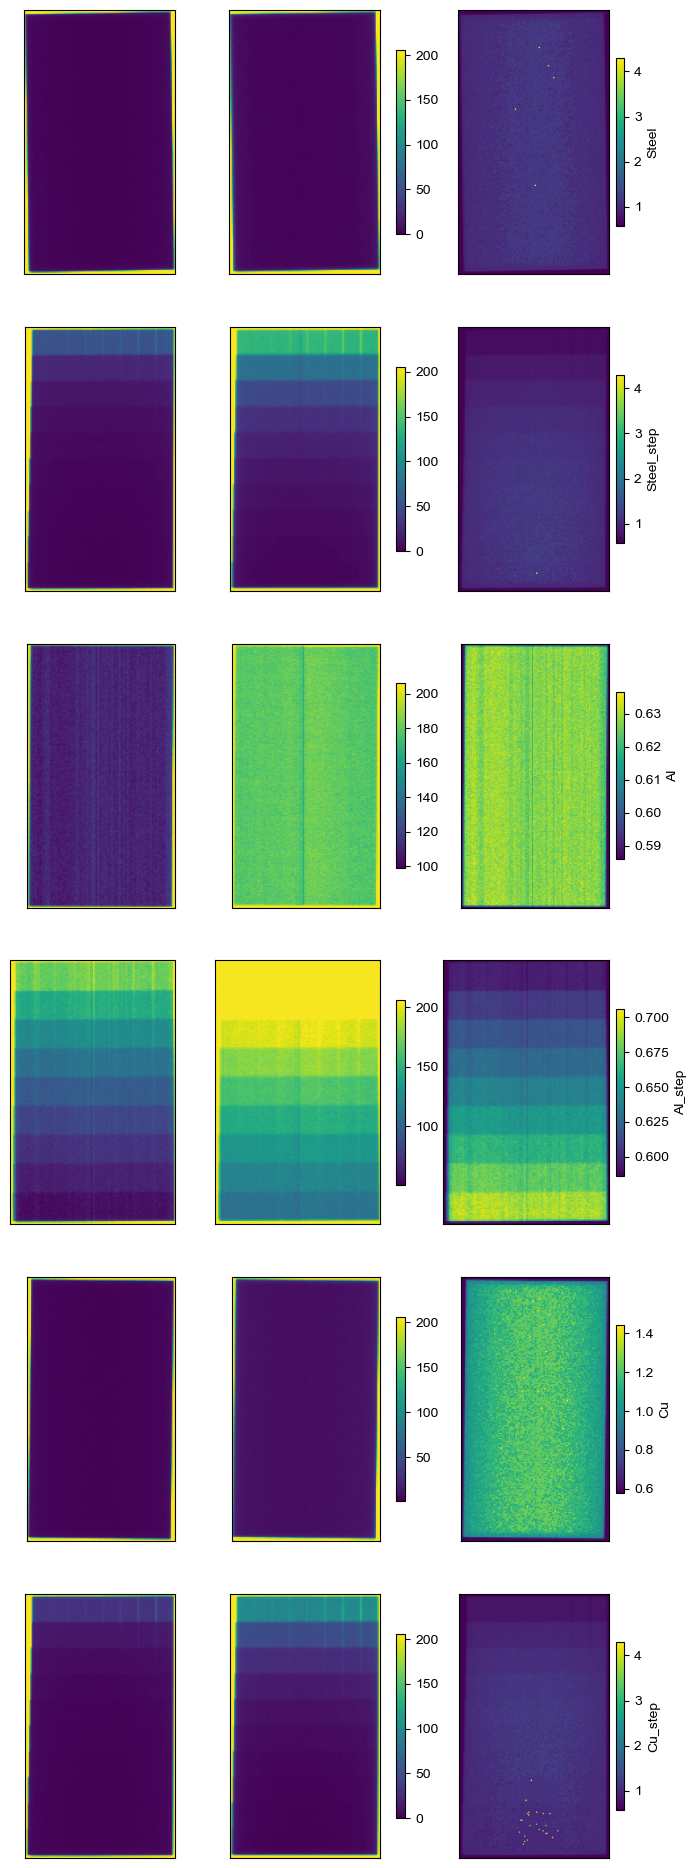

In [202]:
import matplotlib.pyplot as plt
import numpy as np
fig, axes = plt.subplots(6, 3, figsize = (8, 24))

rx_all = []
for kind in range(6):
    al_R = compute_R(box_norm[kind][0], box_norm[kind][1], I0_low = 195, I0_high = 196, input = 'images', method = 'a', const = [5, 20])
    im1 = axes[kind][0].imshow(box_norm[kind][0])
    im2 = axes[kind][1].imshow(box_norm[kind][1], vmin=im1.norm.vmin, vmax=im1.norm.vmax)
    cbar_12 = fig.colorbar(im1, ax=[axes[kind][0], axes[kind][1]], fraction=0.023, pad=0.04)
    
    im3 = axes[kind][2].imshow(al_R)
    cbar3 = fig.colorbar(im3, ax=axes[kind][2], fraction=0.046, pad=0.04, label = names[kind])

    for ax in axes[kind]:
        ax.set_xticks([])
        ax.set_yticks([])

    r_x = []
    for j in range(9):
        r_x.append(np.mean(al_R[(j*20+5):(j*20+15), 10:105]))

    rx_all.append(r_x)

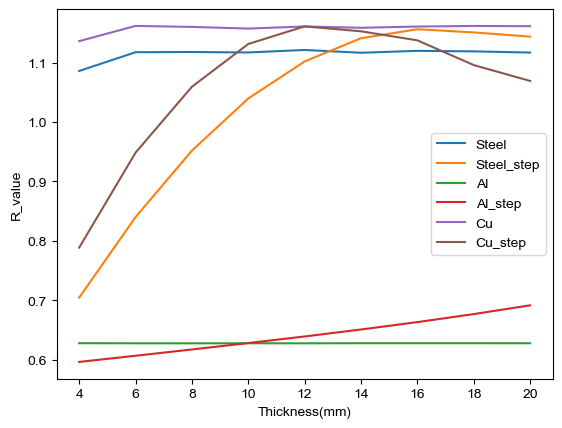

In [210]:
for kind in range(6):
    plt.plot(np.arange(2, 11)*2, rx_all[kind], label = names[kind])
plt.xlabel('Thickness(mm)')
plt.ylabel('R_value')
plt.legend()